# Import

In [1]:
%%capture
pip install --upgrade keras-cv

In [7]:
from google.colab import drive
from numpy import load
from sklearn.model_selection import train_test_split
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import math
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Accuracy, Precision, Recall, CategoricalAccuracy
import tensorflow as tf
import tensorflow.keras as tfk
import tensorflow.keras.layers as tfkl
from tensorflow.keras.layers import LayerNormalization, Dense, Dropout, GlobalAveragePooling2D
from keras import ops
import keras.optimizers
from PIL import Image
from IPython.display import clear_output
import keras_cv
from keras_cv.layers import RandomApply
from tensorflow.keras.callbacks import ReduceLROnPlateau
import matplotlib.ticker as ticker
from tensorflow.keras.callbacks import LearningRateScheduler
import pickle
import matplotlib.colors as mcolors
import matplotlib.cm as cm
from keras.utils import plot_model

In [3]:
drive.mount('/gdrive')
data = load('/gdrive/MyDrive/blood/data_preprocessed_unbalanced.npz', allow_pickle=True)

Mounted at /gdrive


In [4]:
X_train = data['train_images']
y_train = data['train_labels']
X_test = data['val_images']
y_test = data['val_labels']

# Grad Cam

In [5]:
model = keras.models.load_model('/gdrive/MyDrive/blood/blood17xl-10ep17ep.keras', compile=False)
optimizer = tfk.optimizers.Lion(learning_rate=2.5e-6)
model.compile(optimizer=optimizer,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [6]:
import cv2

def upsample_images(images, target_size=(224, 224)):
  upsampled_images = []
  for image in images:
    # Resize the image using cv2.resize
    upsampled_image = cv2.resize(image, target_size, interpolation=cv2.INTER_CUBIC)
    upsampled_images.append(upsampled_image)
  return np.array(upsampled_images)

In [13]:
model.summary(line_length = 190)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━
┃ Layer (type)                                           ┃ Output Shape                                   ┃        
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━
│ input_layer_1 (InputLayer)                             │ (None, 224, 224, 3)                            │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stem (Sequential)                      │ (None, 56, 56, 256)                            │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_depthwise_conv         │ (None, 56, 56, 256)                            │        
│ (Conv2D)                                               │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_layernorm              │ (None, 56, 56, 256)                            │        
│ (LayerNormalization)                                   │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_pointwise_conv_1       │ (None, 56, 56, 1024)                           │        
│ (Dense)                                                │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_gelu (Activation)      │ (None, 56, 56, 1024)                           │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_pointwise_conv_2       │ (None, 56, 56, 256)                            │        
│ (Dense)                                                │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_layer_scale            │ (None, 56, 56, 256)                            │        
│ (LayerScale)                                           │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_0_identity (Activation)  │ (None, 56, 56, 256)                            │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ add (Add)                                              │ (None, 56, 56, 256)                            │        
│                                                        │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_1_depthwise_conv         │ (None, 56, 56, 256)                            │        
│ (Conv2D)                                               │                                                │        
├────────────────────────────────────────────────────────┼────────────────────────────────────────────────┼────────
│ convnext_xlarge_stage_0_block_1_layernorm              │ (None, 56, 56, 256)                            │        
│ (LayerNormalization)                                   │                                                │        
├───────────────────────────────────────────────────────

 Total params: 350,510,600 (1.31 GB)

 Trainable params: 339,480,328 (1.26 GB)

 Non-trainable params: 11,030,272 (42.08 MB)

dot: graph is too large for cairo-renderer bitmaps. Scaling by 0.690079 to fit



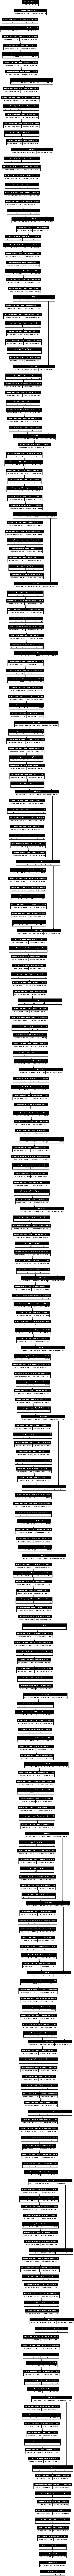

In [12]:
plot_model(
    model,
    show_shapes=True,         # Display layer shapes in the diagram
    show_layer_names=True,    # Display layer names in the diagram
    dpi=96                    # Set resolution for the image
)


In [24]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = keras.models.Model(
        model.inputs, [model.get_layer(last_conv_layer_name).input, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

In [36]:
def superimpose_gradcam(img, heatmap, alpha=1.0):
    img = np.squeeze(img, axis=0)
    img = img * 255

    # Rescale heatmap to a range 0-255
    heatmap = heatmap
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = plt.colormaps["jet"]

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    return superimposed_img

In [16]:
def find_and_display_gradCam(images, model, last_conv_layer_name='convnext_xlarge_stage_2_block_26_depthwise_conv'):
    gradCams = []
    for image in images:
        img = np.expand_dims(image, axis=0)
        img = upsample_images(img)
        heatmap = make_gradcam_heatmap(img, model, last_conv_layer_name)
        gradCams.append(superimpose_gradcam(img, heatmap))

    n_rows = images.shape[0]
    n_cols = 2
    figsize = (n_cols * 4, n_rows * 4)
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes[0, 0].set_title('Original Image')
    axes[0, 1].set_title('Grad-CAM')
    for i in range(n_rows):
        axes[i, 0].imshow(images[i])
        axes[i, 0].axis('off')
        axes[i, 1].imshow(gradCams[i])
        axes[i, 1].axis('off')
    cbar_ax = fig.add_axes([0.25, 0.92, 0.5, 0.02])  # [left, bottom, width, height]
    norm = mcolors.Normalize(vmin=0, vmax=1)  # Adjust min and max to match data range
    cbar = fig.colorbar(cm.ScalarMappable(norm=norm, cmap='jet'),
                        cax=cbar_ax, orientation='horizontal')

    # Set custom tick labels
    cbar.set_ticks([0, 0.5, 1])  # Set tick positions (min and max)
    cbar.set_ticklabels(['Low', 'Medium', 'High'])  # Set tick labels
    cbar.ax.xaxis.set_label_position('top')  # Move label to the top
    cbar.set_label('Importance', labelpad=10)

    plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to accommodate the colorbar
    plt.show()


<ipython-input-16-178786fbce24>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to accommodate the colorbar


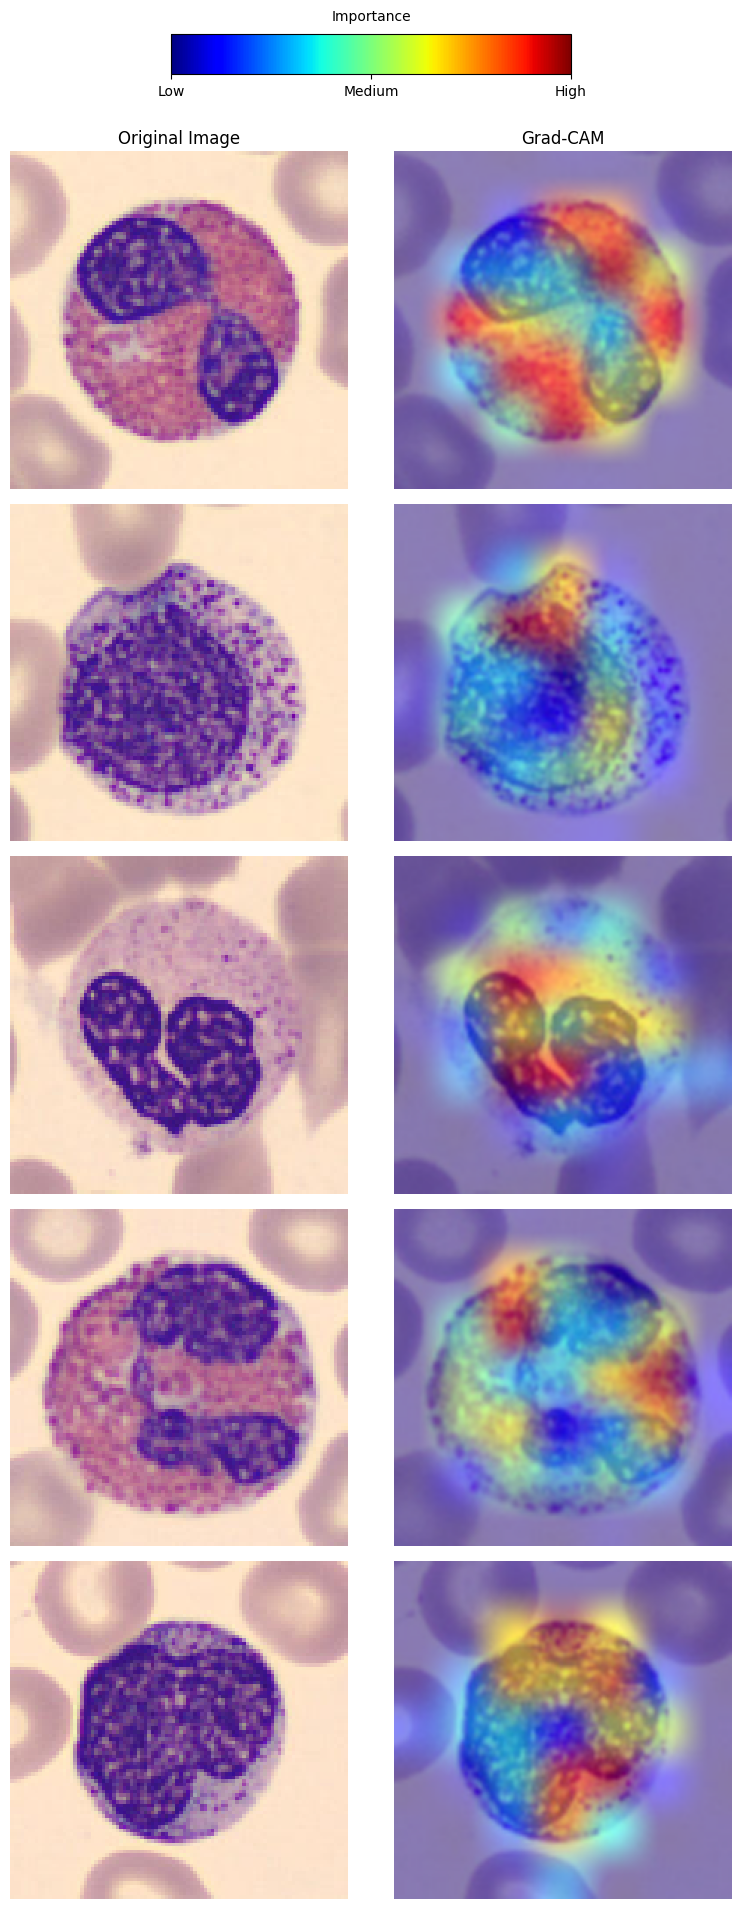

In [40]:
find_and_display_gradCam(X_train[10:15], model, last_conv_layer_name='convnext_xlarge_stage_3_block_2_depthwise_conv')

# Augment grad-cam

In [32]:
random_layers = [
    RandomApply(keras_cv.layers.RandAugment((0, 1)), rate=0.9),
    RandomApply(keras_cv.layers.JitteredResize((96, 96), (0.9, 1)), rate=0.7),
    RandomApply(keras_cv.layers.RandomTranslation(0.4, 0.4), rate=0.6),
    RandomApply(keras_cv.layers.RandomRotation(1), rate=0.6),
    RandomApply(keras_cv.layers.RandomSaturation(0.7), rate=0.3),
    RandomApply(keras_cv.layers.RandomContrast((0, 1), 0.7), rate=0.3),
]

augmenter = tfk.Sequential(random_layers)

In [33]:
aug_samples = augmenter(X_train[:128], training=True);

<ipython-input-16-178786fbce24>:31: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 1, 0.90])  # Adjust layout to accommodate the colorbar


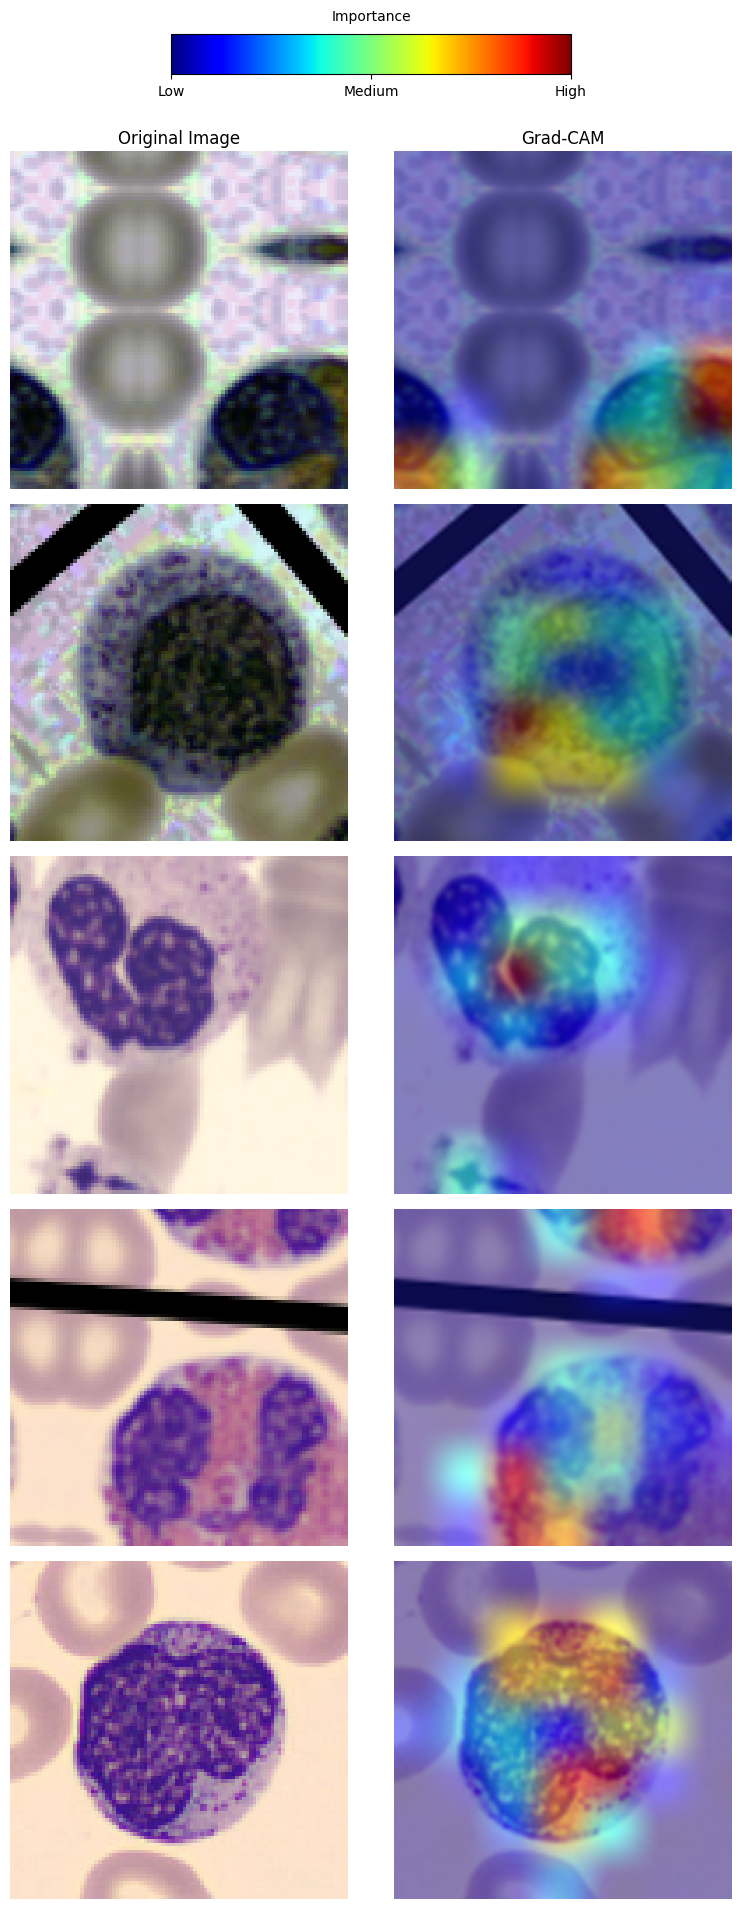

In [41]:
find_and_display_gradCam(aug_samples[10:15], model, last_conv_layer_name='convnext_xlarge_stage_3_block_2_depthwise_conv')